In [1]:
import numpy as np

In [2]:
A = np.zeros((20, 20))

In [3]:
np.random.seed(42)

In [4]:
A_centers=[np.random.choice(20, 2) for i in range(3)]

In [5]:
for y in range(20):
  for x in range(20):
    A[y,x] = np.sum([np.exp(-np.linalg.norm([y_1-y, x_1-x])**2/9) for [y_1,x_1] in A_centers])

In [6]:
import matplotlib.pyplot as plt

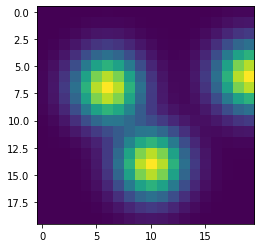

In [7]:
plt.imshow(A)

In [8]:
MAP_DIM=20

In [9]:
def gen_latent_2d(num_centers=3, sigma=9, seed=42):
  rs = np.random.RandomState(seed=seed)
  A = np.zeros((MAP_DIM, MAP_DIM))
  A_centers=[rs.choice(20, 2) for i in range(num_centers)]
  for y in range(MAP_DIM):
    for x in range(MAP_DIM):
      A[y,x] = np.sum([np.exp(-np.linalg.norm([y_1-y, x_1-x])**2/sigma) for [y_1,x_1] in A_centers])
  return A

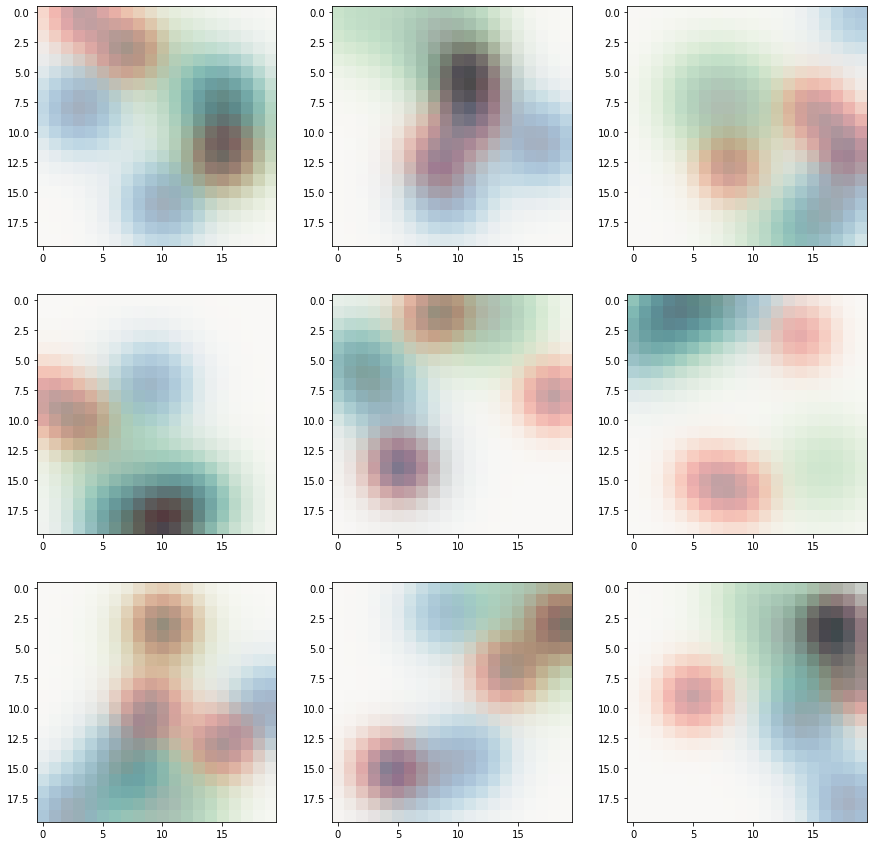

In [10]:
f, axarr = plt.subplots(3,3, figsize=(15,15)) 

for x in range(9):
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=9, seed=x), cmap=plt.cm.Reds)
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=16, seed=100+x), alpha=0.5, cmap=plt.cm.Blues)
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=25, seed=200+x), alpha=0.3, cmap=plt.cm.Greens)

plt.show()

In [11]:
A,B,C = gen_latent_2d(sigma=9, seed=0), gen_latent_2d(sigma=16, seed=100), gen_latent_2d(sigma=25, seed=200)

In [12]:
np.unravel_index(np.random.choice(a=MAP_DIM**2,p=(A.flatten() + B.flatten() + C.flatten())/np.sum(A.flatten() + B.flatten() + C.flatten())), (MAP_DIM, MAP_DIM))

(8, 8)

In [13]:
C_probs=(A.flatten() + B.flatten() + C.flatten())/np.sum(A.flatten() + B.flatten() + C.flatten())

In [14]:
C_rawpreds=np.random.choice(a=MAP_DIM**2, size=20, p=C_probs, replace=False)
C_preds=[np.unravel_index(C_rawpreds, (MAP_DIM, MAP_DIM)) for _ in range(20)]

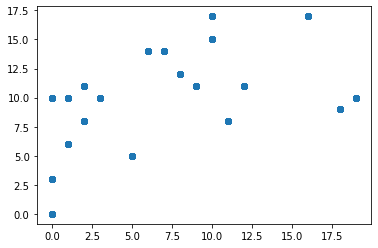

In [15]:
plt.scatter(*zip(*C_preds))

# Transportation Problem

In [16]:
# !pip install ortools

In [17]:
from ortools.linear_solver import pywraplp

In [18]:
solver = pywraplp.Solver.CreateSolver('SCIP')
objective = solver.Objective()

In [19]:
# x_ij denotes a flow from i to j
x_ijs = [[solver.IntVar(0,1,f'x_{i}_{j}') for j in range(MAP_DIM**2)] for i in range(MAP_DIM**2)]

In [20]:
# Objective to minimize the flow

for i in range(MAP_DIM**2):
  for j in range(MAP_DIM**2):
    x = np.unravel_index(i, (MAP_DIM, MAP_DIM))
    y = np.unravel_index(j, (MAP_DIM, MAP_DIM))
    objective.SetCoefficient(x_ijs[i][j], float(abs(x[0]-y[0]) + abs(x[1] - y[1])))

In [21]:
sources = [solver.Constraint(0, 1) for i in range(MAP_DIM**2)]
sinks = [solver.Constraint(1, 1) if i in C_rawpreds else solver.Constraint(0,0) for i in range(MAP_DIM**2)]

In [22]:
for i in range(MAP_DIM**2):
  for j in range(MAP_DIM**2):
    x_ij = x_ijs[i][j]
    sources[i].SetCoefficient(x_ij, 1)
    sinks[j].SetCoefficient(x_ij, 1)

In [23]:
objective.SetMinimization()

In [24]:
solver.Solve()

0

In [25]:
for i in range(MAP_DIM**2):
  for j in range(MAP_DIM**2):
    s=x_ijs[i][j].solution_value()
    if s>0:
      print(f'x_{i}_{j} = {s} * {objective.GetCoefficient(x_ijs[i][j])}')

x_0_0 = 1.0 * 0.0
x_3_3 = 1.0 * 0.0
x_10_10 = 1.0 * 0.0
x_26_26 = 1.0 * 0.0
x_30_30 = 1.0 * 0.0
x_48_48 = 1.0 * 0.0
x_51_51 = 1.0 * 0.0
x_70_70 = 1.0 * 0.0
x_105_105 = 1.0 * 0.0
x_134_134 = 1.0 * 0.0
x_154_154 = 1.0 * 0.0
x_172_172 = 1.0 * 0.0
x_191_191 = 1.0 * 0.0
x_215_215 = 1.0 * 0.0
x_217_217 = 1.0 * 0.0
x_228_228 = 1.0 * 0.0
x_251_251 = 1.0 * 0.0
x_337_337 = 1.0 * 0.0
x_369_369 = 1.0 * 0.0
x_390_390 = 1.0 * 0.0


In [26]:
solver.NumVariables()

160000

In [27]:
solver.NumConstraints()

800

# Transportation over multiple projections

In [251]:
from ortools.sat.python import cp_model
from functools import reduce

In [284]:
# Number of scenarios to run
NUM_S = 10
# Number of resources to deploy
NUM_K = 50

In [291]:
def mincost_flow_model(z_s, q_limit=2):
  model = cp_model.CpModel()
  # Global sources
  q = [model.NewIntVar(0, NUM_K, f'q_i') for i in range(MAP_DIM**2)]
  # Total resource deployed constraint
  model.Add(reduce(lambda x,y:x+y, q) == NUM_K)
  # Transferred unit from i police unit to j crime scene in scenario s
  x_ijs = [[[model.NewIntVar(0, 1, f'x_{i}_{j}_{s}') for s in range(NUM_S)] for j in range(MAP_DIM**2)] for i in range(MAP_DIM**2)]
  # Local sources constraint
  for s in range(NUM_S):
    # Total outbound call from i can be q[i] at max.
    for i in range(MAP_DIM**2):
      model.Add(reduce(lambda x,y: x+y, [x_ijs[i][j][s] for j in range(MAP_DIM**2)]) <= q[i])
  # Sink constraint per scenario
  for s in range(NUM_S):
    z = z_s[s]
    for j in z:
      model.Add(reduce(lambda x,y:x+y, [x_ijs[i][j][s] for i in range(MAP_DIM**2)]) >= 1)
  # Set objective to minimize cost of flow in all given scenarios.
  goals = 0
  for i in range(MAP_DIM**2):
    for j in range(MAP_DIM**2):
      a = np.unravel_index(i, (MAP_DIM, MAP_DIM))
      b = np.unravel_index(j, (MAP_DIM, MAP_DIM))
      d = abs(a[0]-b[0]) + abs(a[1] - b[1])
      for s in range(NUM_S):
        x = x_ijs[i][j][s]
        goals += (x*d)
  # Hard limit on unit deployment
  for q_i in q:
    model.Add(q_i <= q_limit)
  model.Minimize(goals)
  return model, q, x_ijs

In [292]:
# Generate scenarios
np.random.seed(10042)
z_s = [np.random.choice(a=MAP_DIM**2, size=20, p=C_probs, replace=False) for _ in range(NUM_S)]

In [293]:
model_2, q_2, x_ijs_2 = mincost_flow_model(z_s, q_limit=2)

In [294]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 300.0

In [295]:
status = solver.Solve(model_2)

In [296]:
print(status)

2


In [299]:
# Assigned resources.
zx_c={i:solver.Value(q_2[i]) for i in range(MAP_DIM**2) if solver.Value(q_2[i]) > 0}

In [300]:
zx_c

{4: 1,
 17: 2,
 23: 1,
 31: 1,
 34: 2,
 47: 2,
 48: 1,
 68: 2,
 69: 2,
 90: 1,
 93: 1,
 94: 2,
 95: 2,
 124: 1,
 137: 1,
 138: 2,
 153: 2,
 167: 1,
 170: 2,
 186: 1,
 187: 1,
 188: 1,
 189: 1,
 190: 1,
 191: 1,
 192: 1,
 193: 1,
 194: 1,
 239: 1,
 269: 1,
 275: 2,
 276: 2,
 277: 2,
 299: 1,
 366: 1,
 372: 2}

In [304]:
# Assigned positions
zx = list(zx_c.keys())

In [305]:
zx

[4,
 17,
 23,
 31,
 34,
 47,
 48,
 68,
 69,
 90,
 93,
 94,
 95,
 124,
 137,
 138,
 153,
 167,
 170,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 239,
 269,
 275,
 276,
 277,
 299,
 366,
 372]

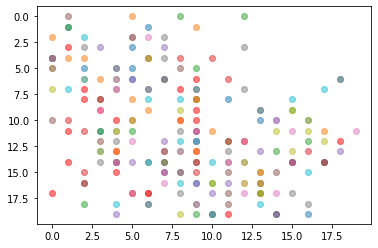

In [307]:
plt.scatter(*np.unravel_index(zx, (MAP_DIM, MAP_DIM)), color='red', alpha=0.5).axes.invert_yaxis()
for z in z_s:
    plt.scatter(*np.unravel_index(z, (MAP_DIM, MAP_DIM)), alpha=0.5).axes.invert_yaxis()
plt.show()

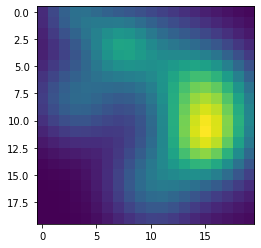

In [308]:
plt.imshow(np.reshape(C_probs, (MAP_DIM, MAP_DIM)))

# Population Assignments

In [228]:
P1 = 0.2 + 0.1 * A + 0.05 * B + 0.001 * C
P2 = 0.2 - 0.001 * A + 0.05 * B

In [229]:
N_POP=500000

In [230]:
def assign_population(prop, seed=42):
  np.random.seed(seed)
  pa = np.zeros((MAP_DIM, MAP_DIM))
  for x in np.random.choice(a=MAP_DIM**2, size=N_POP, p=prop.flatten()/sum(prop.flatten()), replace=True):
    pa[np.unravel_index(x, (MAP_DIM, MAP_DIM))]+=1
  return pa

In [231]:
P1A=assign_population(P1)
P2A=assign_population(P2)

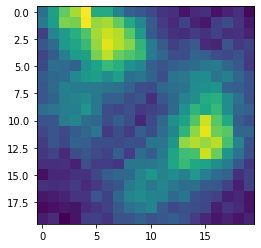

In [232]:
plt.imshow(np.reshape(P1A, (MAP_DIM, MAP_DIM)))

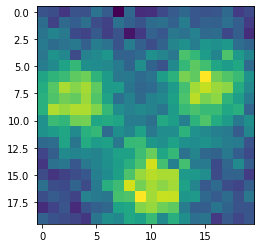

In [233]:
plt.imshow(np.reshape(P2A, (MAP_DIM, MAP_DIM)))

## Assign population to simulated incidents

In [234]:
def local_pick(p1a, p2a, loc):
  n=p1a[loc] + p2a[loc]
  return np.random.choice(a=2, p=[p1a[loc]/n, p2a[loc]/n])


def assign_population(p1a, p2a, z_s, seed=42):
  np.random.seed(seed)
  unraveled = [list(zip(x,y)) for x,y in [np.unravel_index(z, (MAP_DIM, MAP_DIM)) for z in z_s]]
  return np.array([[local_pick(p1a, p2a, loc) for loc in zu] for zu in unraveled])

In [235]:
# [list(zip(x,y)) for x,y in [np.unravel_index(z, (MAP_DIM, MAP_DIM)) for z in z_s]]

In [236]:
pa_s=assign_population(P1A, P2A, z_s)

In [237]:
pa_s

array([[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]])

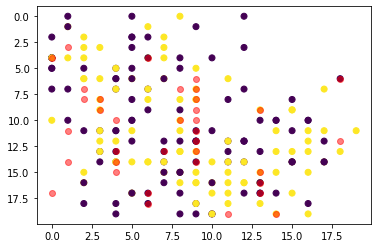

In [306]:
for i, z in enumerate(z_s):
  plt.scatter(*np.unravel_index(z, (MAP_DIM, MAP_DIM)), c=pa_s[i]).axes.invert_yaxis()
plt.scatter(*np.unravel_index(zx, (MAP_DIM, MAP_DIM)), color='red', alpha=0.5).axes.invert_yaxis()
plt.show()

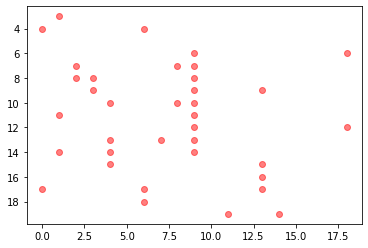

In [271]:
plt.scatter(*np.unravel_index(zx, (MAP_DIM, MAP_DIM)), color='red', alpha=0.5).axes.invert_yaxis()

# Save the model

In [272]:
import pickle

In [273]:
# Latent factors
pickle.dump([A, B, C], open('latent.p', 'wb'))

In [277]:
# Crime probability
pickle.dump(C_probs, open('C_probs.p', 'wb'))

In [274]:
# Population Assignments
pickle.dump([P1A, P2A], open('pop.p', 'wb'))

In [275]:
# Crime simulation
pickle.dump(z_s, open('z_s.p', 'wb'))

In [276]:
# Police Assignment limit=2
pickle.dump(zx, open('zx.p', 'wb'))

In [282]:
zx_c={i:solver.Value(q[i]) for i in range(MAP_DIM**2) if solver.Value(q[i]) > 0}

In [283]:
# Police Assignment count
pickle.dump(zx_c, open('zx_c.p', 'wb'))